# Using TextBlob and Vader as Out of the Box Analysers

This notebook uses two 'Out of the Box' or Rules-based sentiment analysers, TextBlob and Vader to determine the sentiment of the training set reviews. The data is not balanced according to the number of positive and negative reviews, since each review is considered separately against a set of rules within each of these algorithms. The analyser is not learning anything, it is simply treating each review separately and comparing it to a set of rules. The data can be fed raw into the analyser (although cleaning can be used first) and does not need the extensive cleaning of machine learning models, which make them very easy and quick to use.

* Section 1 - import libraries and dataset
* Section 2 - Pre-processing

* Section 2 - analyser performance against sample phrases  
* Section 3 - TextBlob and VADER 
* Section 4 - Comparison of analyser scores with user scores
* Section 5 - VADER scores compared to review length
* Section 6 - Rerunning results with cleaned text
* Section 7 - Summary

*Note: Rating refers to the user rating and score is the binary score allocated - with 1 referring to the majority class of positive reviews and -1 relating to the minority class of negative reviews.*

# Section 1: Import libraries and Dataset

In [103]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [217]:
df_train = pd.read_csv("train_cleaned.csv",index_col = 0)
df_val = pd.read_csv("val_cleaned.csv",index_col = 0)
df_test = pd.read_csv("test_cleaned.csv",index_col = 0)

In [9]:
df_train.head()

,OrgInd,Town,Category,Score,Sent,Sent_clean,Pos
0,245,Bognor,Accommodation,0,"Central B & B We had room 6, excellent view, w...",central room excellent view could see sea room...,"[('central', 'JJ'), ('room', 'NN'), ('excellen..."
1,209,Littlehampton,Accommodation,1,Not what it used to be... We lived in the area...,not used lived area year fact daughter worked ...,"[('not', 'RB'), ('used', 'VBN'), ('lived', 'VB..."
2,28,Bognor,Accommodation,0,Easter Break 5 days at Bognor Stayed in Rockpo...,easter break day stayed rockpool xu apartment ...,"[('easter', 'JJ'), ('break', 'NN'), ('day', 'N..."
3,365,Arundel,Accommodation,0,Fantastic pub inn tucked away at top of Arunde...,fantastic pub tucked away top asunder high str...,"[('fantastic', 'JJ'), ('pub', 'NN'), ('tucked'..."
4,389,Arundel,Accommodation,1,Charging top prices for low quality food Had t...,charging top price low quality food buttermilk...,"[('charging', 'VBG'), ('top', 'JJ'), ('price',..."


In [12]:
df_train = df_train[["Town","Category","Sent","Score"]]
df_val = df_val[["Town","Category","Sent","Score"]]
df_test = df_test[["Town","Category","Sent","Score"]]

In [13]:
df_train.head()

,Town,Category,Sent,Score
0,Bognor,Accommodation,"Central B & B We had room 6, excellent view, w...",0
1,Littlehampton,Accommodation,Not what it used to be... We lived in the area...,1
2,Bognor,Accommodation,Easter Break 5 days at Bognor Stayed in Rockpo...,0
3,Arundel,Accommodation,Fantastic pub inn tucked away at top of Arunde...,0
4,Arundel,Accommodation,Charging top prices for low quality food Had t...,1


# Section 2: Preprocessing

In [14]:
# Put bad reviews as -1 and good reviews as 1
df_train.Score.replace(1, -1, inplace = True)
df_train.Score.replace(0, 1, inplace = True)

In [18]:
# Compare numbers of positive and negative reviews
df_train.Score.value_counts()

 1    727
-1    726
Name: Score, dtype: int64

# Section 3: Testing TextBlob and Vader Against Sample Phrases

In [19]:
# Set up an analyser object for Vader
sia = SentimentIntensityAnalyzer()

In [20]:
# Results function
def pol(text):
    pol1 = TextBlob(text).sentiment.polarity
    pol2 = sia.polarity_scores(text)['compound']
    return pol1, pol2, 

## Capitalisation

In [21]:
# Capitalisation of a word
t1 = "This is the worst restaurant I have ever eaten in"
t2 = "This is the WORST restaurant I have ever eaten in"

In [22]:
sent_1 = pol(t1)
sent_2 = pol(t2)
data1 = pd.DataFrame([sent_1,sent_2],index = ["S1","S2"],columns = ["TextBlob","Vader"])
data1.T

,S1,S2
TextBlob,-1.0000,-1.0000
Vader,-0.6249,-0.7034


* Both analysers are negative but only Vader picks up the intensity of capitalisation

## Word Strength

In [23]:
# Word Strength
t3 = "The food is good"
t4 = "The food is great"
t5 = "The food is incredible"
t6 = "The food is awesome"

In [41]:
sent_3 = pol(t3)
sent_4 = pol(t4)
sent_5 = pol(t5)
sent_6 = pol(t6)
data2 = pd.DataFrame([sent_3,sent_4,sent_5,sent_6],index = ["S3","S4","S5","S6"],columns = ["TextBlob","Vader"])
data2.T

,S3,S4,S5,S6
TextBlob,0.7000,0.8000,0.9,1.0000
Vader,0.4404,0.6249,0.0,0.6249


* TextBlob picks up the increasing intensity of words more effectively than Vader 

## Promotor Words

In [25]:
# Promotor words - modulate intensity
t7 = "The food is good"
t8 = "The food is very good"
t9 = "The food is very very good"

In [42]:
sent_7 = pol(t7)
sent_8 = pol(t8)
sent_9 = pol(t9)
data3 = pd.DataFrame([sent_7,sent_8,sent_9],index = ["S7","S8","S9"],columns = ["TextBlob","Vader"])
data3.T

,S7,S8,S9
TextBlob,0.7000,0.9100,0.9100
Vader,0.4404,0.4927,0.5379


* TextBlob picks up increased instensity from the use of the word 'very'
* Vader picks up the increased intensity from repeated words also

## Double Negation

In [27]:
# Double Negation
t10 = "This is not the worst place in the town, not by any means"

In [28]:
sent_10 = pol(t10)
data4 = pd.DataFrame([sent_10],index = ["S10"],columns = ["TextBlob","Vader"])
data4.T

,S10
TextBlob,-1.0000
Vader,0.5096


* Vader picks up that the review is positive and not negative

## Adjectives

In [29]:
# Adjectives
t11 = "The restaurant is worth visiting"
t12 = "The restaurant is hardly worth visiting"

In [30]:
sent_11 = pol(t11)
sent_12 = pol(t12)
data5 = pd.DataFrame([sent_11,sent_12],index = ["S11","S12"],columns = ["TextBlob","Vader"])
data5.T

,S11,S12
TextBlob,0.3000,0.3000
Vader,0.2263,0.1548


* Vader adjusts the score downwards for the word 'hardly'.

## Punctuation

In [31]:
# Punctuation
t13 = "The food is great"
t14 = "The food is great!"
t15 = "The food is great!!"

In [32]:
sent_13 = pol(t13)
sent_14 = pol(t14)
sent_15 = pol(t15)
data6 = pd.DataFrame([sent_13,sent_14,sent_15],index = ["S13","S14","S15"],columns = ["TextBlob","Vader"])
data6.T

,S13,S14,S15
TextBlob,0.8000,1.0000,1.0000
Vader,0.6249,0.6588,0.6892


* VADER picks up the second exclamation mark.

## Intent

In [33]:
# Intent (sarcasm)
t16 = "Is this the best restaurant in town??"

In [34]:
sent_16 = pol(t16)
data7 = pd.DataFrame([sent_16],index = ["S16"],columns = ["TextBlob","Vader"])
data7.T

,S16
TextBlob,1.0000
Vader,0.6767


* Both analysers return positive to a negative sentiment but Vader does have a lower score

## Contrast

In [35]:
# Mixed sentences - contrast
t17 = "The view is amazing but the food is awful"
t18 = "I loved this place, however it could do with a refurbishment"

In [36]:
sent_17 = pol(t17)
sent_18 = pol(t18)
data8 = pd.DataFrame([sent_17,sent_18],index = ["S17","S18"],columns = ["TextBlob","Vader"])
data8.T

,S17,S18
TextBlob,-0.2000,0.7000
Vader,-0.3818,0.5994


* Both analysers swap from negative to positive between the two sentences.

## Context - ambiguous adjectives and one word, many meanings

In [37]:
# Context - ambiguous adjectives - convey perspective
t19 = "The food is pretty good"
t20 = "The food is pretty bad"

# One word with many meanings (low can be seen as negative but in context of prices it isnt)
t21 = "The prices are high"
t22 = "The prices are low"

In [38]:
sent_19 = pol(t19)
sent_20 = pol(t20)
sent_21 = pol(t21)
sent_22 = pol(t22)
data9 = pd.DataFrame([sent_19,sent_20,sent_21,sent_22],index = ["S19","S20","S21","S22"],columns = ["TextBlob","Vader"])
data9.T

,S19,S20,S21,S22
TextBlob,0.4750,-0.2250,0.16,0.0000
Vader,0.7269,-0.0772,0.00,-0.2732


* Both analysers deal with the first two sentences 

## Emojis

In [157]:
t23 = "Love this place"
t24 = "Love this place :)"
sent_23 = pol(t23)
sent_24 = pol(t24)

In [159]:
data10 = pd.DataFrame([sent_23,sent_24],index = ["S23","S24"],columns = ["TextBlob","Vader"])
data10.T

,S23,S24
TextBlob,0.5000,0.500
Vader,0.6369,0.802


# Section 4: Passing All Reviews Through TextBlob and Vader

In [69]:
# Run TextBlob against each review in the dataframe
df_train["Polarity"] = df_train["Sent"].apply(lambda x: TextBlob(x).sentiment.polarity)
df_train["Subjectivity"] = df_train["Sent"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Round TextBlob polarity
#df_train.Polarity = df_train.Polarity.apply(lambda x: round(x,2))
#df_train.Subjectivity = df_train.Subjectivity.apply(lambda x: round(x,2))

In [70]:
# Run VADER against each review in the dataframe
df_train["VNeg"] = df_train["Sent"].apply(lambda x: sia.polarity_scores(x)['neg'])
df_train["VNeu"] = df_train["Sent"].apply(lambda x: sia.polarity_scores(x)['neu'])
df_train["VPos"] = df_train["Sent"].apply(lambda x: sia.polarity_scores(x)['pos'])
df_train["VComp"] = df_train["Sent"].apply(lambda x: sia.polarity_scores(x)['compound'])

In [71]:
# Check basic descriptive statistics
df_train.describe()

,Score,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score
count,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000
mean,0.000688,0.163928,0.561965,0.065449,0.747056,0.187495,0.391645,0.285616
std,1.000344,0.270587,0.118932,0.071461,0.107764,0.133375,0.744444,0.451863
min,-1.000000,-0.812500,0.111111,0.000000,0.365000,0.000000,-0.991100,0.000000
25%,-1.000000,-0.028388,0.484615,0.000000,0.680000,0.078000,-0.361200,0.000000
50%,1.000000,0.166875,0.556667,0.045000,0.760000,0.158000,0.875000,0.000000
75%,1.000000,0.369792,0.639955,0.104000,0.827000,0.275000,0.968100,1.000000
max,1.000000,0.950000,1.000000,0.414000,1.000000,0.635000,0.999400,1.000000


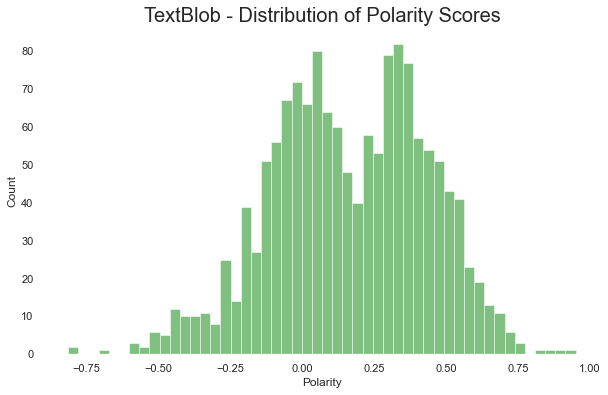

In [72]:
# Look at how the Polarity scores are distributed - TextBlob
num_bins = 50

fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor("White")
n, bins, patches = plt.hist(df_train.Polarity, num_bins, facecolor='green', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('TextBlob - Distribution of Polarity Scores',size = 20)
plt.show();

In [73]:
# How many reviews have positive, neutral and negative sentiment?
print(df_train[df_train["Polarity"] >= 0.01].shape[0])
print(df_train[(df_train["Polarity"] >-0.01) & (df_train["Polarity"]<0.01)].shape[0])
print(df_train[df_train["Polarity"] <= -0.01].shape[0])

1003
45
405


In [74]:
# Get skew
df_train.Polarity.skew()

-0.22933829756514126

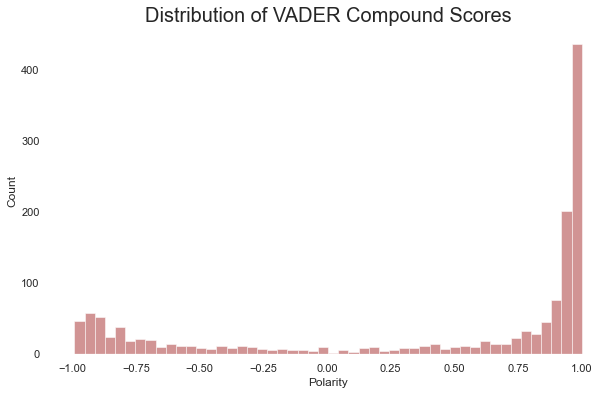

In [75]:
# Plot Vader Compound Scores
num_bins = 50
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor("White")
n, bins, patches = plt.hist(df_train.VComp, num_bins, facecolor='brown', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Distribution of VADER Compound Scores', fontsize = 20)
plt.show();

In [76]:
# How many reviews have sentiment above and below 0.05 threshold suggested in the documentation
print(df_train[df_train["VComp"] >= 0.05].shape[0])
print(df_train[(df_train["VComp"] <0.05) & (df_train["VComp"] > -0.05)].shape[0])
print(df_train[df_train["VComp"] <= -0.05].shape[0])

1015
15
423


In [77]:
# Get skew of VComp distribution
df_train.VComp.skew()

-0.8407105437634207

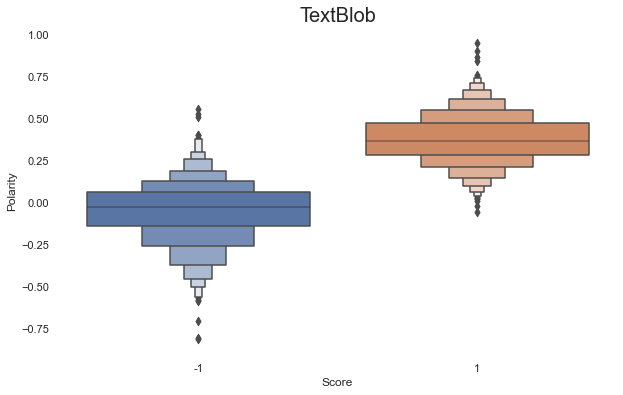

In [78]:
# Look at the Distribution of Polarity with regard to Ratings
fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
sns.boxenplot(x='Score', y='Polarity', data=df_train)
plt.title("TextBlob",fontsize = 20)
plt.show();

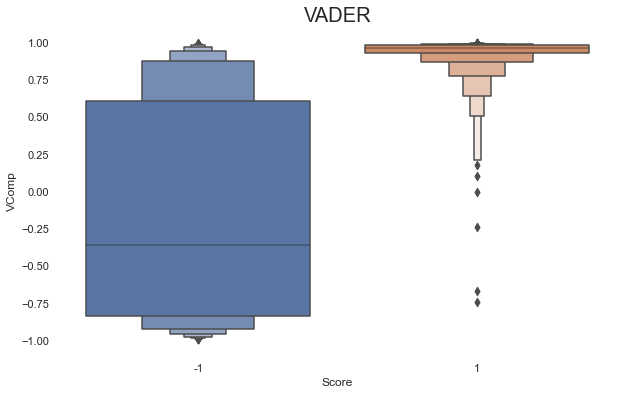

In [79]:
# Look at the Distribution of VADER Compound Score with regard to Ratings
fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
sns.boxenplot(x='Score', y='VComp', data=df_train)
plt.title("VADER", fontsize = 20)
plt.show();

* TextBlob scores are slightly negatively skewed with bimodal distribution
* VADER's distribution is heavily negatively skewed
* The TextBlob boxplot shows negative reviews only just below zero score and positive between 0.25 and 0.50 
* VADER scores most reviews as strongly positive and there are outliers.  
* The boxplot for VADER shows greater variation in the compound polarity for negative reviews compared to positive. 

# Section 4: Comparison of Analyser Scores with User Rating

### TextBlob

Uses a weighted average score over all the words in a sentence

In [88]:
# Check for any polaritiy scores that are zero or neutral sentiment
df_train[df_train["Polarity"] == 0]

,Town,Category,Sent,Score,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score
1176,Bognor,Food,Overcharged on the bill £29. We were a party o...,-1,0.0,0.5,0.061,0.796,0.143,0.4767,-1


In [89]:
# Set polarities greater than zero 1 and polarities less than zero to -1 
# Assume for ease that polarity >0 is positive and <=0 is negative, so any neutral polarities are ignored

conditions = [(df_train["Polarity"]>0),df_train["Polarity"]<=0]
choices = [1,-1]
df_train["TB_score"] = np.select(conditions,choices,default = 'null')
df_train["TB_score"] = df_train["TB_score"].astype('int64')

In [106]:
df_train["TB_score"].value_counts()

 1    1028
-1     425
Name: TB_score, dtype: int64

In [107]:
# Value counts of scores - 1 is positive reviews and -1 is negative reviews
df_train["Score"].value_counts()

 1    727
-1    726
Name: Score, dtype: int64

In [91]:
df_train.head(3)

,Town,Category,Sent,Score,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score
0,Bognor,Accommodation,"Central B & B We had room 6, excellent view, w...",1,0.214026,0.513420,0.032,0.853,0.115,0.9217,1
1,Littlehampton,Accommodation,Not what it used to be... We lived in the area...,-1,0.145588,0.493627,0.045,0.918,0.037,0.1296,1
2,Bognor,Accommodation,Easter Break 5 days at Bognor Stayed in Rockpo...,1,0.318723,0.501515,0.000,0.796,0.204,0.9685,1


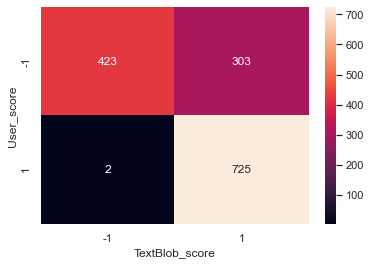

In [92]:
confusion_matrix = pd.crosstab(df_train['Score'], df_train['TB_score'], rownames=['User_score'], colnames=['TextBlob_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

Noting that the -1 is actually the positive class in this case (i.e. the class we are interested in representing negative reviews) and the +1 is actually the negative class (the class representing good reviews that we are not interested in).

In [150]:
# Metrics function (pos_label = -1 as that represents negative reviews which is the class we are interested in)
def metrics(y_true,y_pred):
    a = accuracy_score(y_true, y_pred)*100
    p = precision_score(y_true, y_pred,pos_label = -1)*100
    r = recall_score(y_true, y_pred,pos_label = -1)*100
    f1 = f1_score(y_true, y_pred,pos_label = -1)*100
    roc = roc_auc_score(y_true,y_pred)*100
    
    return a,p,r,f1,roc

In [151]:
metrics(df_train['Score'], df_train['TB_score'])

(79.00894700619409,
 99.52941176470588,
 58.26446280991735,
 73.50130321459599,
 78.99467982311548)

### VADER

A compound score greater than and equal to 0.05 is positive and negative is <= 0.05. Neutral is defined by VADER as between -0.05 and 0.05. 

In [163]:
# How many instances are affected by this (ie how many does VADER say are neutral)
df_train[(df_train["VComp"]>-0.05) & (df_train["VComp"]<0.05)]

,Town,Category,Sent,Score,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score
309,Arundel,Accommodation,Sunday lunch Heard the news that this is the p...,-1,-0.083333,0.522222,0.033,0.935,0.032,-0.0129,-1
354,Bognor,Food,Flies Went in for a sandwiches. Used toilet fi...,-1,0.072222,0.111111,0.000,1.000,0.000,0.0000,1
472,Arundel,Food,Very disappointing Went today with a friend at...,-1,-0.238333,0.568333,0.062,0.875,0.063,0.0475,-1
480,Littlehampton,Food,Disappointed I went to lunch with my friend wh...,-1,-0.342840,0.732099,0.113,0.773,0.113,-0.0018,-1
484,Bognor,Food,Dissapointed Used to order a decent take away ...,-1,-0.108333,0.804167,0.000,1.000,0.000,0.0000,-1
554,Littlehampton,Food,Hair in food.. not the first timw We always or...,-1,0.024038,0.433013,0.062,0.867,0.071,0.0260,1
572,Littlehampton,Food,Long wait Very very very long wait defidently...,-1,-0.177798,0.529524,0.019,0.981,0.000,-0.0387,-1
600,Bognor,Food,Flies Went in for a sandwiches. Used toilet fi...,-1,0.072222,0.111111,0.000,1.000,0.000,0.0000,1
782,Arundel,Food,"Slow service. Visited earlier in the week, ear...",-1,-0.040972,0.391667,0.000,1.000,0.000,0.0000,-1
876,Littlehampton,Food,"All day breakfast, not The menu states all day...",-1,-0.300000,0.600000,0.000,1.000,0.000,0.0000,-1


Most of these are actually scored as bad reviews by users so we will treat compound scores between -0.05 and +0.05 as negative. Therefore good reviews are compound score of 0.05 and above and bad reviews as compound score of less than 0.05.

In [173]:
# Set polarities greater than equal to zero to zero (majority class) and polarities less than zero to 1 (minority class)
conditions = [(df_train["VComp"]>=0.05),
              df_train["VComp"]<0.05]
choices = [1,-1]
df_train["VComp_score"] = np.select(conditions,choices,default = 'null')
df_train["VComp_score"] = df_train["VComp_score"].astype('int32')

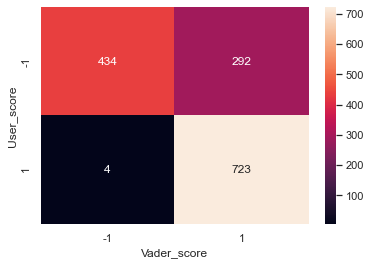

In [174]:
confusion_matrix = pd.crosstab(df_train['Score'], df_train['VComp_score'], rownames=['User_score'], colnames=['Vader_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

In [175]:
df_train["VComp_score"].value_counts()

 1    1015
-1     438
Name: VComp_score, dtype: int64

In [176]:
metrics(df_train['Score'], df_train['VComp_score'])

(79.62835512732278,
 99.08675799086758,
 59.77961432506888,
 74.5704467353952,
 79.61470399884804)

* Both analysers had similar metrics with Vader achieving slightly better accuracy and recall
* Neither did as well with the bad reviews, misclassifying many of them as good reviews

In [177]:
# Examine some reviews that VADER set as negative but user score was positive
wrong = df_train[df_train["Score"] != df_train["VComp_score"]]
wrong_neg = wrong[wrong["VComp_score"] == 1]
wrong_neg.head(2)

,Town,Category,Sent,Score,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score
1,Littlehampton,Accommodation,Not what it used to be... We lived in the area...,-1,0.145588,0.493627,0.045,0.918,0.037,0.1296,1,1
4,Arundel,Accommodation,Charging top prices for low quality food Had t...,-1,-0.015476,0.441071,0.074,0.797,0.130,0.7399,-1,1


In [178]:
wrong_neg.shape

(292, 12)

In [183]:
wrong_neg["Sent"].iloc[0]

'Not what it used to be... We lived in the area for 25 years and in fact, my daughter worked at The Seaview bar some years ago when she was a student. We always sent visitors there when our house was full, it was our preferred local hostelry.\nSo it wasn\'t surprising we booked a room for 4 nights at The Seaview when we went back last week, and sent them a message through the booking site advising we would be bringing our dog (they are listed as dog friendly on the site).\nWhen booking in, my wife was rather surprised to be told they were not going to accept dogs in future. We were also told the room had no furniture (?) as the dog was staying - we were glad it had 2 beds... - and basically, please pay upfront and don\'t come back.\nThe rate included breakfast and I ordered a cooked breakfast and my wife asked for a boiled egg - the lady said: "We don\'t do boiled eggs." so she had toast. When we returned the beds were un-made and the bathroom wasn\'t cleaned nor towels replaced. The h

In [184]:
wrong_neg["Sent"].iloc[1]

'Charging top prices for low quality food Had the buttermilk chicken burger from the pub menu. The chicken steaklets were clearly over cooked. They definitely were not freshly prepared and likely bought in bulk at an Iceland store. Same goes for the french fries. This would be all good and well for the local pub. This is however a Hilton restaurant charging £15 for a low quality burger. My advice would be to go elsewhere, no matter how hungry you might be.\nRead less'

In [185]:
# Examine some reviews that VADER set as positive but user score was negative
wrong_pos = wrong[wrong["VComp_score"] == -1]
wrong_pos.head(2)

,Town,Category,Sent,Score,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score
553,Arundel,Food,One of many! Arundel is a real tourist hotspot...,1,0.290025,0.548889,0.109,0.822,0.069,-0.7405,1,-1
899,Littlehampton,Food,Plants and food yippee Haskins garden centre h...,1,0.050000,0.625000,0.000,1.000,0.000,0.0000,1,-1


In [186]:
wrong_pos.shape

(4, 12)

In [187]:
wrong_pos["Sent"].iloc[0]

"One of many! Arundel is a real tourist hotspot. Our granddaughter wanted to go there because it sounds like the place in 'Frozen'!!!!!\nTook a break to have a sit down and coffee and teacake. Nice place, good service, but there were so many tea places to choose from!\nOnly problem was the toilets were upstairs - my poor old knees! THAT'S why we live in a bungalow!\nTry the place yourself."

In [188]:
wrong_pos["Sent"].iloc[1]

'Plants and food yippee Haskins garden centre has a wide selection of plants and shrubs, if you can’t get it here then it’s very possible you won’t find it around. Also they do a wide range of meals, light snacks and coffee/tea. '

* Vader misclassified more negative reviews as positive than the reverse
* Looking at examples, these appear to be quite long and/or contain mixed sentiments

# Section 5: Relationship VADER polarity and length of review

Does the length of review affect the polarity that VADER gives?

## VADER classed as positive when the user score is negative

In [205]:
# Looking at reviews VADER misclassified as positive when they are scored negative by the user
wrong_neg["Num_tokens"] = wrong_neg["Sent"].apply(lambda x: len(nltk.word_tokenize(x)))

In [207]:
wrong_neg.head()

,Town,Category,Sent,Score,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score,Num_tokens
1,Littlehampton,Accommodation,Not what it used to be... We lived in the area...,-1,0.145588,0.493627,0.045,0.918,0.037,0.1296,1,1,310
4,Arundel,Accommodation,Charging top prices for low quality food Had t...,-1,-0.015476,0.441071,0.074,0.797,0.130,0.7399,-1,1,92
10,Bognor,Accommodation,Seen Better Days We stayed here for two nights...,-1,-0.005764,0.590000,0.048,0.780,0.173,0.8550,-1,1,83
15,Arundel,Accommodation,"Not great. The room was hot, the fan supplied ...",-1,-0.119667,0.596667,0.188,0.659,0.152,0.1758,-1,1,57
20,Arundel,Accommodation,Wedding Anniversary On arrival my husband and...,-1,0.100139,0.582222,0.052,0.834,0.113,0.9794,1,1,332


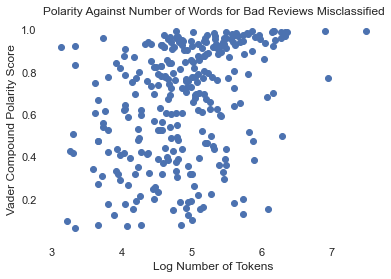

In [213]:
# Plot a scatter plot of the number of tokens and the vader compound polarity score - log used to spread data out
fig, ax = plt.subplots()
ax.set_facecolor("White")
plt.scatter(x = np.log(wrong_neg["Num_tokens"]), y = wrong_neg["VComp"])
plt.xlabel("Log Number of Tokens")
plt.ylabel("Vader Compound Polarity Score")
ax = plt.title("Polarity Against Number of Words for Bad Reviews Misclassified")

In [209]:
# Correlation between the two series
pd.Series.corr(wrong_pos["Num_tokens"],wrong_pos["VComp"])

-0.3862763045143224

Seems that the longer the review the more likely VADER is to class it as positive, thereby perhaps missing longer bad reviews

 # VADER classed as negative when the user score is positive

In [210]:
# Looking at reviews VADER misclassified as negative when they are scored positive by the user
wrong_pos["Num_tokens"] = wrong_pos["Sent"].apply(lambda x: len(nltk.word_tokenize(x)))

In [212]:
wrong_pos.head()

,Town,Category,Sent,Score,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score,Num_tokens
553,Arundel,Food,One of many! Arundel is a real tourist hotspot...,1,0.290025,0.548889,0.109,0.822,0.069,-0.7405,1,-1,88
899,Littlehampton,Food,Plants and food yippee Haskins garden centre h...,1,0.050000,0.625000,0.000,1.000,0.000,0.0000,1,-1,52
1103,Bognor,Food,Never lets us down ! Our favourite place to ea...,1,0.124938,0.304365,0.118,0.832,0.049,-0.6671,1,-1,61
1141,Arundel,Food,Lovely roast dinner! Great roast dinner with ...,1,0.281364,0.668182,0.079,0.834,0.087,-0.2363,1,-1,89


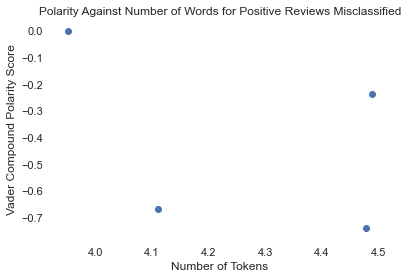

In [214]:
fig, ax = plt.subplots()
ax.set_facecolor("White")
plt.scatter(x = np.log(wrong_pos["Num_tokens"]), y = wrong_pos["VComp"])
plt.xlabel("Number of Tokens")
plt.ylabel("Vader Compound Polarity Score")
ax = plt.title("Polarity Against Number of Words for Positive Reviews Misclassified")

In [215]:
pd.Series.corr(wrong_neg["Num_tokens"], wrong_neg["VComp"])

0.300972092693382

# Section 6: Run the models with cleaned reviews

In [226]:
df_train = pd.read_csv("train_cleaned.csv",index_col = 0)
df_val = pd.read_csv("val_cleaned.csv",index_col = 0)
df_test = pd.read_csv("test_cleaned.csv",index_col = 0)

In [227]:
df_train_cleaned = df_train[["Town","Category","Sent_clean","Score"]]
df_val_cleaned = df_val[["Town","Category","Sent_clean","Score"]]
df_test_cleaned = df_test[["Town","Category","Sent_clean","Score"]]

In [228]:
df_train_cleaned.Score.replace(1, -1, inplace = True)
df_train_cleaned.Score.replace(0, 1, inplace = True)

In [229]:
# Run TextBlob against each review in the dataframe
df_train_cleaned["Polarity"] = df_train_cleaned["Sent_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)
df_train_cleaned["Subjectivity"] = df_train_cleaned["Sent_clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [230]:
# Run VADER against each review in the dataframe
df_train_cleaned["VNeg"] = df_train_cleaned["Sent_clean"].apply(lambda x: sia.polarity_scores(x)['neg'])
df_train_cleaned["VNeu"] = df_train_cleaned["Sent_clean"].apply(lambda x: sia.polarity_scores(x)['neu'])
df_train_cleaned["VPos"] = df_train_cleaned["Sent_clean"].apply(lambda x: sia.polarity_scores(x)['pos'])
df_train_cleaned["VComp"] = df_train_cleaned["Sent_clean"].apply(lambda x: sia.polarity_scores(x)['compound'])

In [231]:
conditions = [(df_train_cleaned["Polarity"]>0),df_train_cleaned["Polarity"]<=0]
choices = [1,-1]
df_train_cleaned["TB_score"] = np.select(conditions,choices,default = 'null')
df_train_cleaned["TB_score"] = df_train_cleaned["TB_score"].astype('int64')

In [232]:
# Set polarities greater than equal to zero to zero (majority class) and polarities less than zero to 1 (minority class)
conditions = [(df_train_cleaned["VComp"]>=0.05),
              df_train_cleaned["VComp"]<0.05]
choices = [1,-1]
df_train_cleaned["VComp_score"] = np.select(conditions,choices,default = 'null')
df_train_cleaned["VComp_score"] = df_train_cleaned["VComp_score"].astype('int32')

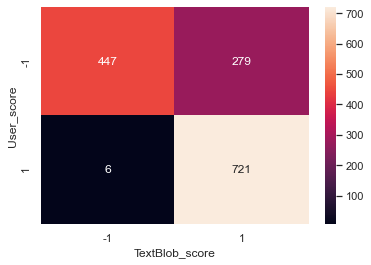

In [233]:
confusion_matrix = pd.crosstab(df_train_cleaned['Score'], df_train_cleaned['TB_score'], rownames=['User_score'], colnames=['TextBlob_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

In [234]:
metrics(df_train_cleaned['Score'], df_train_cleaned['TB_score'])

(80.38540949759118,
 98.67549668874173,
 61.57024793388429,
 75.82697201017811,
 80.37246922141259)

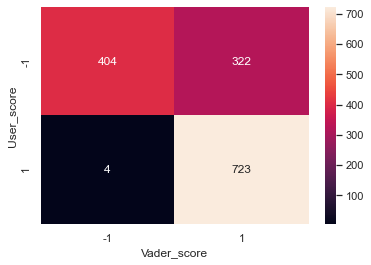

In [235]:
confusion_matrix = pd.crosstab(df_train_cleaned['Score'], df_train_cleaned['VComp_score'], rownames=['User_score'], colnames=['Vader_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

In [236]:
metrics(df_train_cleaned['Score'], df_train_cleaned['VComp_score'])

(77.56366139022711,
 99.01960784313727,
 55.64738292011019,
 71.25220458553791,
 77.54858829636872)

# Section 7: Summary

Summary

* There appears to be a negative relationship between the length of review and the VADER score.
* For negative reviews misclassified as positive, the longer reviews are more positive 
* There are very few good reviews misclassed as bad reviews.
* Therefore where people write long and negative reviews VADER does not always pick up the negative sentiment and tends to classify the review as positive
* When the data was cleaned, VADER's results got worse but TextBlob's improved (with the exception of precision)
* Recall on both is still fairly low, with the best recall of % on TextBlob with the cleaned text.

The Rules Based Sentiment Analysers achieve good accuracy but recall is poor. They appear to struggle with longer review text when classifying "Bad" reviews. They do not appear to account for context well in these cases. Machine Learning techniques may perform better.